In [2]:
import gzip
from io import StringIO
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import re
import string
import json
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim import matutils

In [3]:
def gzip_file_to_documents_list(file_name, languages_filter=['en']):
    with gzip.open(file_name, 'rb') as f:
        decompressed_data = f.read()
    df_data = pd.read_csv(StringIO(str(decompressed_data,'utf-8')), index_col=0)
    documents = df_data[df_data['language'].isin(languages_filter)]['text'].tolist()
    return documents

In [4]:
def uctd_file_name_by_date(month, day):
    return '0'*int(month < 10) + str(month) + '0'*int(day < 10) + str(day) + "_UkraineCombinedTweetsDeduped.csv.gzip"

In [5]:
def get_uctd_documents_between_dates(start: str, end: str,
                                     languages_filter=['en'], verbose: int = 0):
    # Dates in the 'YYYY-DD-MM' format
    date_start = datetime.strptime(start, '%Y-%m-%d')
    date_end = datetime.strptime(end, '%Y-%m-%d')
    delta_days = date_end - date_start
    all_documents = []
    for i_d in range(delta_days.days + 1):
        date_current = date_start + timedelta(days=i_d)
        uctd_file_name = uctd_file_name_by_date(date_current.month, date_current.day)
        all_documents += gzip_file_to_documents_list(uctd_file_name, languages_filter=languages_filter)
        if verbose == 1:
            print(f'--Documents for the day {date_current.date()} processed')
    return all_documents

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /home/oleksii/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/oleksii/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/oleksii/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
class LSAPipelineEnglish:
    def __init__(self, documents_list, tf_idf_max_df=1.0, tf_idf_min_df=1,
                 lsa_components: int = 100, svd_n_iter: int = 5,
                 n_top_words: int = 10, ngram_range: tuple = (1, 1),
                 import_preprocessed_documents: bool = False, random_state: int = -1):
        self.import_documents_list = EnglishPreprocessor().preprocess_documents(documents_list)
        if not import_preprocessed_documents:
            self.import_documents_list = EnglishPreprocessor().preprocess_documents(documents_list,)
        else:
            self.import_documents_list = documents_list
        self.tf_idf_max_df = tf_idf_max_df
        self.tf_idf_min_df = tf_idf_min_df
        self.lsa_components = lsa_components
        self.svd_n_iter = svd_n_iter
        self.n_top_words = n_top_words
        self.ngram_range = ngram_range
        self.random_state = random_state
        self.coherence_texts_calculated = False

    def run_topics_detection(self):
        tfidf_documents = self.TF_IDF()
        self.TruncatedSVD(tfidf_documents)
        self.topics = self.find_topics()
        return self.topics

    def transform_documents(self, new_documents_list: list):
        return list(map(np.argmax, self.svd_model.transform(
            self.tfidf_vectorizer.transform(new_documents_list))))

    def import_ready_documents(self, documents_list, texts, dictionary, corpus):
        self.import_documents_list = documents_list
        self.texts = texts
        self.dictionary = dictionary
        self.corpus = corpus
        self.coherence_texts_calculated = True

    def TF_IDF(self):
        self.tfidf_vectorizer = TfidfVectorizer(max_df=self.tf_idf_max_df,
                                                min_df=self.tf_idf_min_df,
                                                ngram_range=self.ngram_range,
                                                stop_words='english')
        return self.tfidf_vectorizer.fit_transform(self.import_documents_list)
        # tfidf_feature_names = self.tfidf_vectorizer.get_feature_names_out()
    
    def TruncatedSVD(self, tfidf_documents):
        if self.random_state != -1:
            self.svd_model = TruncatedSVD(n_components=self.lsa_components,
                                 n_iter=self.svd_n_iter, random_state=self.random_state)
        else:
            self.svd_model = TruncatedSVD(n_components=self.lsa_components,
                                 n_iter=self.svd_n_iter)
        self.svd_model.fit_transform(tfidf_documents)

    def find_topics(self):
        # Extract the top words for each topic
        topics = []
        tfidf_feature_names = self.tfidf_vectorizer.get_feature_names_out()
        for topic_idx, topic in enumerate(self.svd_model.components_):
            top_features_ind = topic.argsort()[:-self.n_top_words - 1:-1]
            top_features = [tfidf_feature_names[i] for i in top_features_ind]
            topics.append(top_features)
        return topics

    def calculate_coherence_score(self, recalculate_texts: bool = False, verbose: int = 0):
        if not self.coherence_texts_calculated or recalculate_texts:
            self.calculate_coherence_texts(verbose=verbose)
        # Calculate the coherence score using Gensim
        coherence_model = CoherenceModel(topics=self.topics,
                                         texts=self.texts,
                                         dictionary=self.dictionary,
                                         coherence='c_v')
        if verbose == 1:
            print(f'--Calculating the coherence score')
        self.coherence_score = coherence_model.get_coherence()
        return self.coherence_score

    def calculate_coherence_texts(self, verbose: int = 0):
        # Convert the list of top words into a list of lists of words
        tfidf_feature_names = set(self.tfidf_vectorizer.get_feature_names_out())
        if verbose == 1:
            print(f'--Starting forming the texts')
        self.texts = [[word for word in doc.lower().split() if (
            word in tfidf_feature_names)] for doc in self.import_documents_list]
        # Create a Gensim dictionary
        if verbose == 1:
            print(f'--Creating the Gensim dectionary')
        self.dictionary = Dictionary(self.texts)
        # Convert the dictionary and the corpus
        if verbose == 1:
            print(f'--Converting to the corpus')
        self.corpus = [dictionary.doc2bow(text) for text in self.texts]
        self.coherence_texts_calculated = True

In [8]:
class EnglishPreprocessor:
    def preprocess_documents(self, documents_list: list, return_strings: bool = True):
        return [self.preprocess(doc, return_string=return_strings) for doc in documents_list]
    
    # Function to preprocess documents
    def preprocess(self, document, return_string: bool = True):
        # Tokenize
        document = self.remove_links_content(document)
        document = self.remove_emails(document)
        document = self.remove_multiple_space(document)
        document = self.remove_hashtags(document)
        document = self.remove_punctuation(document)
        document = self.remove_multiple_space(document)
        
        words = word_tokenize(document.lower())
        # Remove stopwords and punctuations
        filtered_words = [word for word in words if word.isalnum() and not word in stop_words]
        # Lemmatize
        lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
        if return_string:
            return ' '.join(lemmatized_words)
        else:
            return lemmatized_words
    
    def remove_links_content(self, text):
        text = re.sub(r"http\S+", "", text)
        return text
    
    def remove_emails(self, text):
        return re.sub('\S+@\S*\s?', '', text)
    
    def remove_punctuation(self, text):
        """https://stackoverflow.com/a/37221663"""
        table = str.maketrans({key: None for key in string.punctuation})
        return text.translate(table)
    
    def remove_multiple_space(self, text):
        return re.sub("\s\s+", " ", text)

    def remove_hashtags(self, text):
        old_text = text + '\n'
        new_text = text
        while len(new_text) < len(old_text):
            old_text = new_text
            new_text = re.sub('(?<=[\s\n])#\S+\s*$', '', new_text)
        return new_text

In [9]:
def tokenize_ngrams(document, n_g):
    return [' '.join(ngram) for ngram in ngrams(document.lower().split(), n_g)]

In [10]:
all_documents_092022 = get_uctd_documents_between_dates('2023-09-01','2023-09-07',verbose=1)

--Documents for the day 2023-09-01 processed
--Documents for the day 2023-09-02 processed
--Documents for the day 2023-09-03 processed
--Documents for the day 2023-09-04 processed
--Documents for the day 2023-09-05 processed
--Documents for the day 2023-09-06 processed
--Documents for the day 2023-09-07 processed


In [11]:
LSAPipeline = LSAPipelineEnglish(all_documents_092022, tf_idf_max_df=0.9, tf_idf_min_df=4,
                                 lsa_components=5, svd_n_iter=5,
                                 n_top_words=10, ngram_range=(1,2),
                                 random_state=47)
topics_v6 = LSAPipeline.run_topics_detection()

In [12]:
topics_v6

[['ukraine',
  'russia',
  'russian',
  'war',
  'ukrainian',
  'putin',
  'amp',
  'force',
  'people',
  'biden'],
 ['psg',
  'juventus',
  'psg juventus',
  'celtic',
  'sevilla',
  'realmadrid',
  'juventus sevilla',
  'celtic realmadrid',
  'manchestercity',
  'madrid'],
 ['barbarism limit',
  'ukrainewillwin crimeabelongstoukraine',
  'limit peace',
  'zaporizhzhiabelongstoukraine russia',
  'crimeabelongstoukraine zaporizhzhiabelongstoukraine',
  'peace possible',
  'zaporizhzhiabelongstoukraine',
  'defeated ukrainian',
  'russian barbarism',
  'crimeabelongstoukraine'],
 ['biden',
  'trump',
  'putin',
  'amp',
  'russia',
  'speech',
  'president',
  'maga',
  'china',
  'like'],
 ['russian',
  'biden',
  'ukrainian',
  'kherson',
  'force',
  'region',
  'trump',
  'soldier',
  'city',
  'armed']]

In [13]:
tfidf_feature_names = set(LSAPipeline.tfidf_vectorizer.get_feature_names_out())
preprocessed_documents = LSAPipeline.import_documents_list

In [14]:
# Convert the list of ngrams into a list of lists of words
texts_v6 = [[word for word in doc.lower().split() if (
    word in tfidf_feature_names)] + tokenize_ngrams(doc, 2) for doc in preprocessed_documents]

# Create a Gensim dictionary
dictionary_v6 = Dictionary(texts_v6)

# Convert the dictionary and the corpus
corpus_v6 = [dictionary_v6.doc2bow(text) for text in texts_v6]

## 1- and 2-grams: optimal topics number

Model that uses both 1- and 2-grams for the different topics numbers for the data for September 2022.

In [15]:
topic_numbers_12grams = list(range(2,15)) + [20,30,40,50,100,150,200]
coherences_12grams = []
predicted_topics_counts_12grams = []
for topic_number in topic_numbers_12grams:
    LSAPipeline = LSAPipelineEnglish(preprocessed_documents, tf_idf_max_df=0.9, tf_idf_min_df=4,
                                 lsa_components=topic_number, svd_n_iter=5,
                                 n_top_words=10, ngram_range=(1,2),
                                 import_preprocessed_documents=True, random_state=47)
    topics_12grams = LSAPipeline.run_topics_detection()
    tfidf_feature_names = set(LSAPipeline.tfidf_vectorizer.get_feature_names_out())
    # Calculate the coherence score using Gensim
    coherence_model = CoherenceModel(topics=topics_12grams,
                                     texts=texts_v6,
                                     dictionary=dictionary_v6,
                                     corpus=corpus_v6,
                                     coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    predicted_topics = LSAPipeline.transform_documents(LSAPipeline.import_documents_list)
    predicted_topics_count = [predicted_topics.count(x) for x in np.sort(np.unique(predicted_topics))]
    
    print(f'--Topic number {topic_number} coherence score: {coherence_score}')
    coherences_12grams.append(coherence_score)
    predicted_topics_counts_12grams.append(predicted_topics_count)

--Topic number 2 coherence score: 0.691398020766523
--Topic number 3 coherence score: 0.7942653009700834
--Topic number 4 coherence score: 0.7160588274053125
--Topic number 5 coherence score: 0.6600930556317682
--Topic number 6 coherence score: 0.6280567932849495
--Topic number 7 coherence score: 0.5746005482969287
--Topic number 8 coherence score: 0.5375397500208946
--Topic number 9 coherence score: 0.5730298850163672
--Topic number 10 coherence score: 0.5562080118155334
--Topic number 11 coherence score: 0.581543046806252
--Topic number 12 coherence score: 0.585344329648921
--Topic number 13 coherence score: 0.5655677584956507
--Topic number 14 coherence score: 0.5661272625162456
--Topic number 20 coherence score: 0.4892754981112586
--Topic number 30 coherence score: 0.4707701776372751
--Topic number 40 coherence score: 0.4103981700800386
--Topic number 50 coherence score: 0.4329878603503856
--Topic number 100 coherence score: 0.3935700536387348
--Topic number 150 coherence score: 0.

In [16]:
with open('coherences_12grams.json','w') as json_file:
    json.dump({'coherences': coherences_12grams,
               'predicted_topics': predicted_topics_counts_12grams}, json_file)

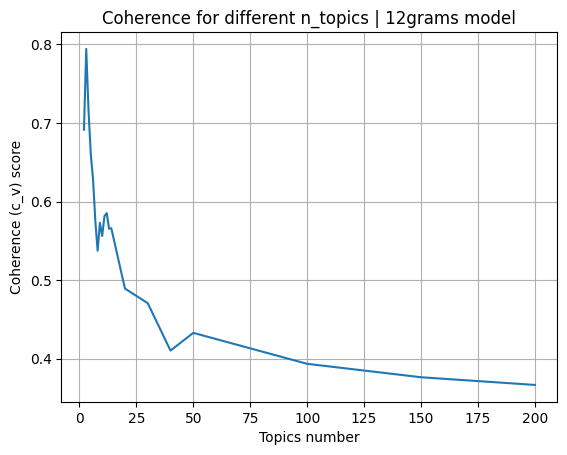

In [17]:
plt.plot(topic_numbers_12grams, coherences_12grams)
plt.title('Coherence for different n_topics | 12grams model')
plt.xlabel('Topics number')
plt.ylabel('Coherence (c_v) score')
plt.grid()
plt.show()